In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
df = pd.read_csv('hr_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8995 entries, 0 to 8994
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SLNO                         8995 non-null   int64  
 1   Candidate Ref                8995 non-null   int64  
 2   DOJ Extended                 8995 non-null   object 
 3   Duration to accept offer     8995 non-null   int64  
 4   Notice period                8995 non-null   int64  
 5   Offered band                 8995 non-null   object 
 6   Pecent hike expected in CTC  8995 non-null   float64
 7   Percent hike offered in CTC  8995 non-null   float64
 8   Percent difference CTC       8995 non-null   float64
 9   Joining Bonus                8995 non-null   object 
 10  Candidate relocate actual    8995 non-null   object 
 11  Gender                       8995 non-null   object 
 12  Candidate Source             8995 non-null   object 
 13  Rex in Yrs        

In [2]:
from sklearn.utils import shuffle
joined_counts = df['Status'].value_counts()['Joined'];
not_joined_counts = df['Status'].value_counts()['Not Joined'];
joined_precentage = (joined_counts)/(joined_counts + not_joined_counts)
not_joined_percentage = 1 - joined_precentage

print("percentage of people who joined : ", 100*joined_precentage)
print("percentage of people who not joined : ", 100*not_joined_percentage)


#1. Upsampling the dataset as not joined are less than 33%
joined = df[df.Status == 'Joined']
not_joined = df[df.Status == 'Not Joined']

# Upsampling the Not joined cases
upsampled_not_joined = resample(not_joined, replace = True, n_samples = 4000)

# Combining the upsampled
dfs = [joined, upsampled_not_joined]
new_df = pd.concat(dfs)
new_df = shuffle(new_df)

percentage of people who joined :  81.30072262367982
percentage of people who not joined :  18.69927737632018


In [3]:
from sklearn.neighbors import KNeighborsClassifier
#10.1 (i) Knn model
X_features = new_df[['DOJ Extended', 'Duration to accept offer', 'Notice period', 'Offered band', 'Pecent hike expected in CTC', 'Percent hike offered in CTC', 'Percent difference CTC', 'Joining Bonus', 'Candidate relocate actual', 'Gender', 'Candidate Source', 'Rex in Yrs', 'LOB', 'Location', 'Age']]
Y_features = new_df['Status']

X = pd.get_dummies(X_features, drop_first=True)
Y = new_df.Status.map(lambda x: int(x == 'Joined'))

train_X, test_X, train_Y, test_Y = train_test_split(X,Y,train_size=0.8, random_state=42) 

## Initializing the classifier
knn_clf = KNeighborsClassifier()
## Fitting the model with the training set
knn_clf.fit( train_X, train_Y )

KNeighborsClassifier()

In [4]:
from sklearn import metrics
def draw_roc_curve( model, test_X, test_y ):
    test_results_df = pd.DataFrame( { 'actual': test_y } )
    test_results_df = test_results_df.reset_index()
    # predict the probabilities on the test set
    predict_proba_df = pd.DataFrame( model.predict_proba( test_X ) )
    ## selecting the probabilities that the test example belongs
    ## to class 1
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2]
    ## Invoke roc_curve() to return fpr, tpr and threshold values.
    ## Threshold values contain values from 0.0 to 1.0
    fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual,
    test_results_df.chd_1,
    drop_intermediate = False )
    ## Getting roc auc score by invoking metrics.roc_auc_score method
    auc_score = metrics.roc_auc_score( test_results_df.actual,
    test_results_df.chd_1 )
    ## Setting the size of the plot
    plt.figure(figsize=(8, 6))
    ## Plotting the actual fpr and tpr values
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % auc_score)
    ## Plotting th diagnoal line from (0,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ## Setting labels and titles
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')

def draw_cm( actual, predicted ):
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    sn.heatmap(confusion_matrix, annot=True, fmt='.2f', xticklabels=["Joined", "Not Joined"], yticklabels=["Joined", "Not Joined"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


TypeError: cannot unpack non-iterable NoneType object

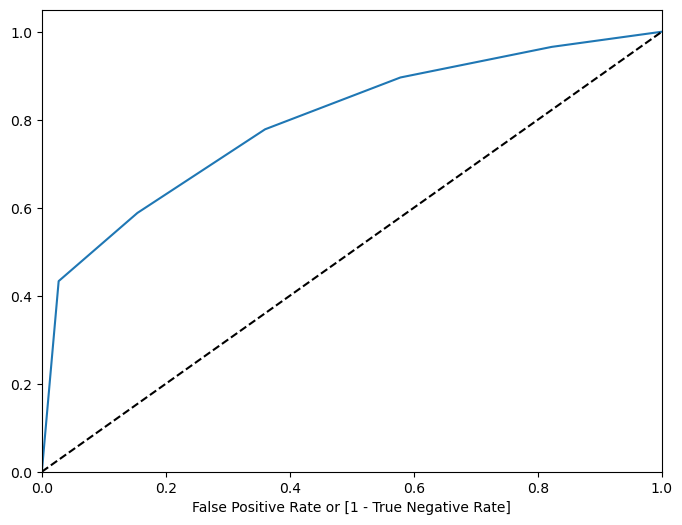

In [5]:
# Analysing accuracy of knn using ROC 
_, _, _, _ = draw_roc_curve( knn_clf, test_X, test_Y )

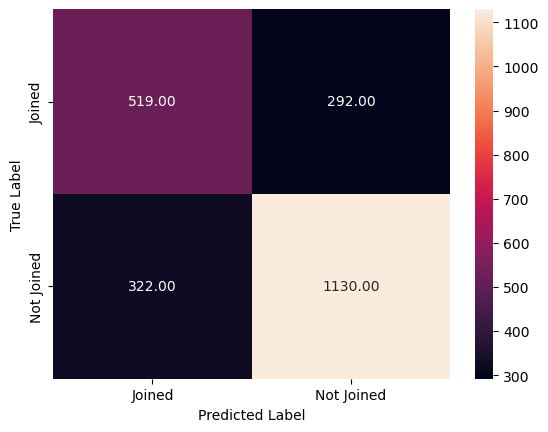

In [6]:
# Analysing knn using confusion matrix
pred_Y_KNN = knn_clf.predict(test_X)
draw_cm(test_Y, pred_Y_KNN)

In [7]:
# Analysing using model summary
print( metrics.classification_report( test_Y, pred_Y_KNN ) )

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       811
           1       0.79      0.78      0.79      1452

    accuracy                           0.73      2263
   macro avg       0.71      0.71      0.71      2263
weighted avg       0.73      0.73      0.73      2263



In [8]:
# 10.1 (ii) Make the model using random forest
from sklearn.ensemble import RandomForestClassifier
## Initializing the Random Forest Classifier with max_dept and
## n_estimators
radm_clf = RandomForestClassifier(max_depth=10, n_estimators=10)
radm_clf.fit( train_X, train_Y )

RandomForestClassifier(max_depth=10, n_estimators=10)

TypeError: cannot unpack non-iterable NoneType object

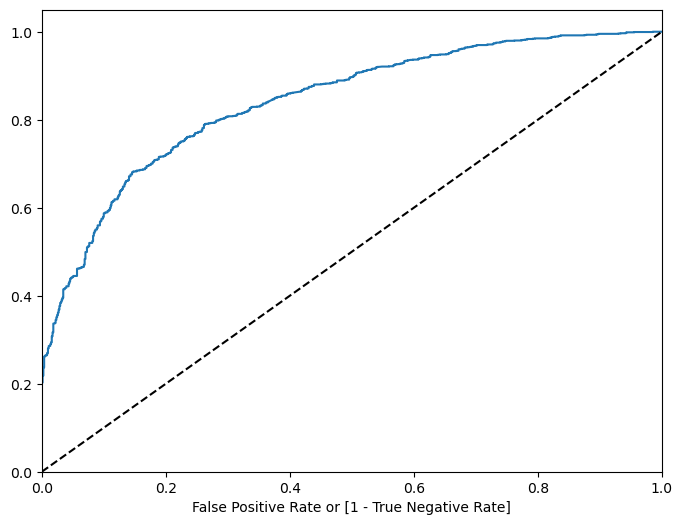

In [9]:
# Making ROC curve of random forest
_, _, _, _ = draw_roc_curve( radm_clf, test_X, test_Y);

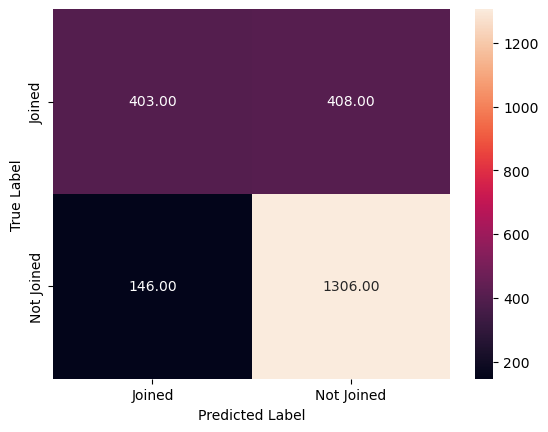

In [10]:
# Analysing Random forest using confusion matrix
pred_Y_RF = radm_clf.predict(test_X)
draw_cm(test_Y, pred_Y_RF)

In [11]:
# Printing the model summary using random forest
print( metrics.classification_report( test_Y, pred_Y_RF ) )

              precision    recall  f1-score   support

           0       0.73      0.50      0.59       811
           1       0.76      0.90      0.83      1452

    accuracy                           0.76      2263
   macro avg       0.75      0.70      0.71      2263
weighted avg       0.75      0.76      0.74      2263



In [12]:
# 10.1 (iii) Using adaboost to build the model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
## Initializing logistic regression to use as base classifier
logreg_clf = LogisticRegression()
## Initializing AdaBoost classifier with 50 classifers
ada_clf = AdaBoostClassifier(logreg_clf, n_estimators=50)
## Fitting AdaBoost model to training set
ada_clf.fit(train_X, train_Y)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AdaBoostClassifier(estimator=LogisticRegression())

TypeError: cannot unpack non-iterable NoneType object

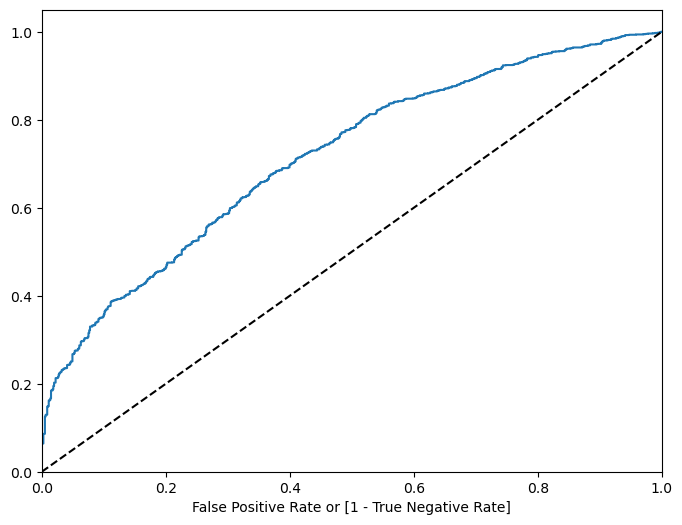

In [13]:
_, _, _, _ = draw_roc_curve( ada_clf, test_X, test_Y )

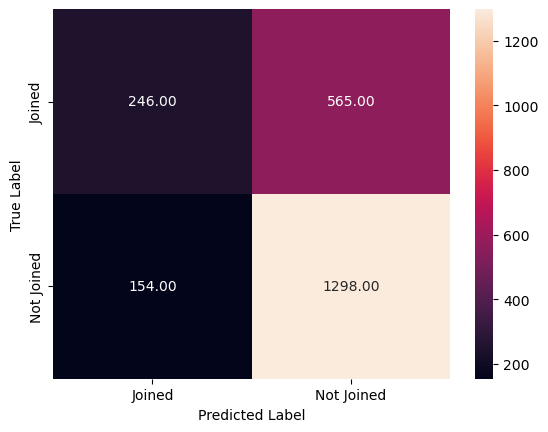

In [14]:
# Analysing Random forest using confusion matrix
pred_Y_AB = ada_clf.predict(test_X)
draw_cm(test_Y, pred_Y_AB)

In [ ]:
# Printing the model summary using random forest
print( metrics.classification_report( test_Y, pred_Y_AB ) )

In [ ]:
# 10.1 (iv) making using svm
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')  # You can change the kernel as needed (e.g., 'linear', 'rbf', 'poly', etc.)
svm_model.fit(train_X, train_Y)

In [ ]:
# Analysing Random forest using confusion matrix
pred_Y_SVM = svm_model.predict(test_X)
draw_cm(test_Y, pred_Y_SVM)

In [ ]:
# Printing the model summary using random forest
print( metrics.classification_report( test_Y, pred_Y_SVM ) )

In [ ]:
# 10.2 Finding optimal parameters using grid search for knn model
from sklearn.model_selection import GridSearchCV
## Creating a dictionary with hyperparameters and possible values
## for searching
tuned_parameters = [{ 'n_neighbors': range(5,10),'metric': ['canberra', 'euclidean','minkowski']}]
## Configuring grid search
clf = GridSearchCV( KNeighborsClassifier(),tuned_parameters,cv=10,scoring='roc_auc')
## fit the search with training set
clf.fit(train_X, train_Y)

In [ ]:
print("Best score for KNN is : ",clf.best_score_)
print("Best parameter for KNN is : ", clf.best_params_)

In [ ]:
clf.cv_results_